In [1]:
from models import ResNet
from utils import common
from utils import modelhelper
device = common.get_dst_device()
model = ResNet.ResNet18().to(device)
modelhelper.print_model_summary(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [2]:
from utils import dataloader
from utils import transforms

train_loader = dataloader.setup_train_loader("data", transforms.train_transform)
test_loader = dataloader.setup_test_loader("data", transforms.test_transform)



Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([128, 3, 32, 32])


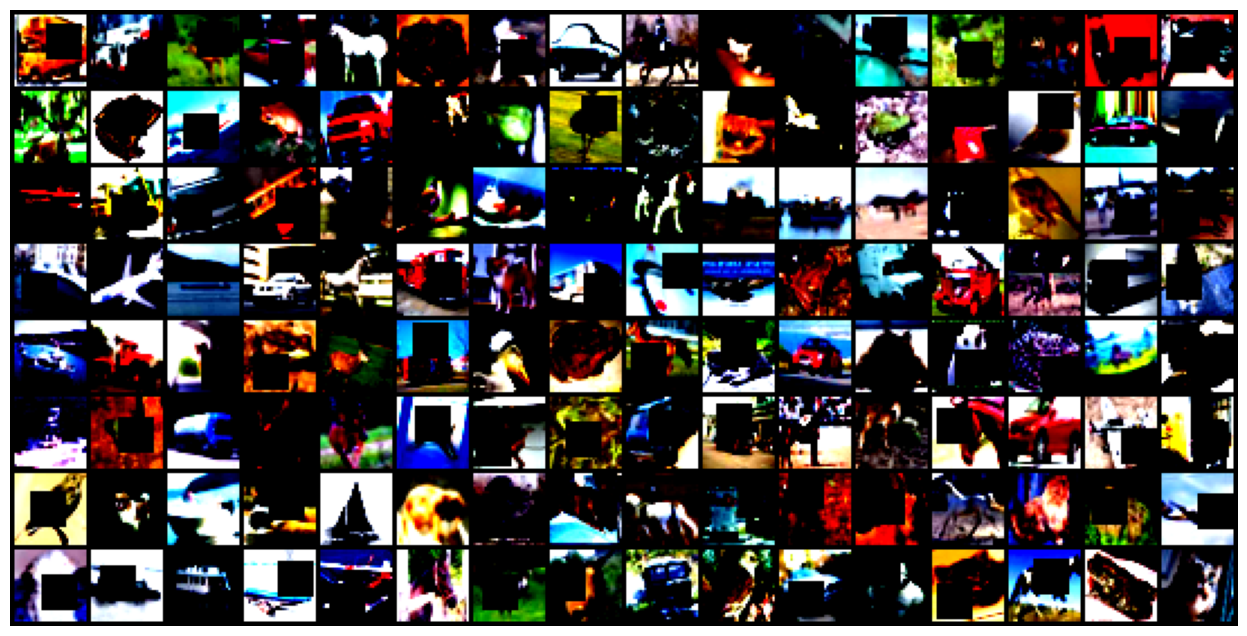

In [3]:
from utils import visualize
visualize.visualize_transforms(train_loader)


In [3]:
import torch.optim as optim
import torch.nn as nn

# Optimization algorithm to update the weights
LEARNING_RATE = 0.03
WEIGHT_DECAY = 1e-4
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=WEIGHT_DECAY)

# Loss Function
criterion = nn.CrossEntropyLoss()

In [ ]:
from torch_lr_finder import LRFinder
lr_finder2 = LRFinder(model, optimizer, criterion, device=device)
lr_finder2.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder2.plot()
lr_finder2.reset()

In [4]:
EPOCHS = 20

MAX_LR = 6.79E-02    # Suggested LR
STEPS_PER_EPOCH = len(train_loader)

In [5]:
import torch.optim as optim
from utils import modelhelper
import torch_lr_finder as tlrf

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
learning_rates = []
test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

# Scheduler
scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=MAX_LR,
                                                steps_per_epoch=STEPS_PER_EPOCH,
                                                epochs=EPOCHS,
                                                pct_start=int(0.3*EPOCHS)/EPOCHS if EPOCHS != 1 else 0.5,   # 30% of total number of Epochs
                                                div_factor=100,
                                                three_phase=False,
                                                final_div_factor=100,
                                                anneal_strategy="linear"
                                                )

# For each epoch
for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}')

    # Train the model on training dataset and append the training loss and accuracy
    train_acc, train_loss = modelhelper.train_model(model, device, train_loader, optimizer, criterion)
    train_accuracies.append(train_acc)
    train_losses.append(train_loss)
    # learning_rates.append((optimizer))
    scheduler.step()

    # Test the model's performance on test dataset and append the training loss and accuracy
    test_acc, test_loss = modelhelper.test_model(model, device, test_loader, criterion)
    test_accuracies.append(test_acc)
    test_losses.append(test_loss)

/Users/tamilselvan.rs/anaconda3/lib/python3.10/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Epoch 1


Train: Loss=2.2630 Batch_id=6 Accuracy=11.50:   2%|▏         | 7/391 [00:30<23:48,  3.72s/it]  

In [ ]:
from utils import plots

plots.plot_results(train_accuracies, train_losses, test_accuracies, test_losses)

In [ ]:
import torch

torch.save(model.state_dict(), "model.pth")


In [ ]:
model.load_state_dict(torch.load("model.pth"), strict=False)

In [ ]:
from utils import modelhelper
from utils import visualize
from torchvision import transforms

# Denormalize the data using test mean and std deviation
inv_normalize = transforms.Normalize(
    mean=[-0.50/0.23, -0.50/0.23, -0.50/0.23],
    std=[1/0.23, 1/0.23, 1/0.23]
)

# Plot the misclassified data
modelhelper.print_incorrect_preds(model, device, test_loader, inv_normalize, number_of_samples=20)